In [361]:
from astropy.table import Table
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import statistics
import scipy 
from condensation_temperature import * 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [362]:
t= Table.read('solar_twins_data.fits') #fits file as table 

In [363]:
def find_stellar_abundances(star):
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r) #list of elements recorded in star

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp')) #table of temperature vs abundance for elements 
    return star_table

In [364]:
#function for returning the best slope and intercept using linear algebra
#[m b] = [A^T C^-1 A]^-1 [A^T C^-1 Y]
def find_m_b(x,y,err):
    safe = np.isfinite(y)
    x = x[safe]
    y = y[safe]
    err = err[safe]
    print(err)
    
    errorsq = np.square(err)
    C = np.diag(errorsq)
    xb = ([1] * len(x))
    mata = []
        
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
            
    A= np.matrix(mata).reshape((len(x), 2))
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)
        
    m_= float(cov[0])
    b_= float(cov[1])
    return m_,b_ 

In [365]:
#jackknife method for determining other possible values of m and b 
def jackknifemb(_tp,_ab,_er):
    N=1000
    l=list(np.copy(_tp))
    k=list(np.copy(_ab))
    s=list(np.copy(_er))
    jackm= []
    jackb= [] 
    h=0
    
    #leaving out one point from data set and calculating m, b for each instance
    while h<N:
        w = random.randint(0, 29)
        del l[w]
        del k[w]
        del s[w] #removing one data set from lists 
    
        jk_mb = find_m_b(l,k,s)
        jk_m = jk_mb[0]
        jk_b = jk_mb[1]

        jackm.append(jk_m)
        jackb.append(jk_b)
            
        l=list(np.copy(_tp))
        k=list(np.copy(_ab))
        s=list(np.copy(_er))
        h=h+1 
        
    return jackm, jackb

In [366]:
def stellar_abundance_plot(star): 
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    new=np.array(star_con_temp)
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r)

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))

    plt.scatter(star_con_temp, star_abundance)
    plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
    plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
    plt.title('Temperature vs Element Abundance for {0}'.format(star), fontsize= 'xx-large', family='sans-serif')

    #point labels
    for i, txt in enumerate(star_elements):
            plt.annotate(txt, xy=(star_con_temp[i], star_abundance[i]), xytext=(-13,-6), 
                textcoords='offset points', ha='center', va='bottom')
            
    jk= jackknifemb(star_con_temp, star_abundance, el_error)
    for i, txt in enumerate (jk[0]):
        plt.scatter(star_con_temp, star_abundance)
        plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
        plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
        plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')

        temparray=np.array(star_con_temp)
        plot_xs = np.arange(0, 1750, .1)
        plt.plot(plot_xs, jk[0][i] * plot_xs + (jk[1][i]), color = 'lightgray', linewidth=0.1)
    
    #error bars
    plt.errorbar(star_con_temp, star_abundance, yerr= el_error, fmt='o', color='black',
                 ecolor='lightsteelblue', elinewidth=3,capsize=0)
    
    #line of best fit m,b values

    mb = find_m_b(star_con_temp, star_abundance, el_error)    
    plot_xs = np.arange(1750)
    plt.plot(plot_xs, (mb[0]) * plot_xs + (mb[1]), color='teal') 
    plt.savefig(star+'.png')

In [367]:
#chi squared :  [Y - AX]^T C^-1 [Y - AX]
def chisquared(param, x, y, erro): 
    ab = ([1] * len(x))
    Amat = []
    for z, txt in enumerate(x):
        Amat.append(x[z])
        Amat.append(ab[z])  
    A= np.array(Amat).reshape((len(x), 2))

    errorsq = np.square(erro)
    C = np.diag(errorsq)
    invsC = np.linalg.inv(C)

    AT= np.transpose(A)
    part1 = np.dot(AT, np.dot(invsC, A))
    invprt1= np.linalg.inv(part1)
    part2 = np.dot(AT, np.dot(invsC, y)).T
    X = np.dot(invprt1, part2)
    [X[0], X[1]] = param
    AX = np.dot(A,X)
    
    yax = (y - AX)
    yaxT = np.transpose(yax)
    yaxTinvsC = np.dot(yaxT, invsC)

    chisq = (np.dot(yaxTinvsC, yax))
    return (chisq)

In [368]:
def standardslopeerror(tem, abund, err):
    errorsq = np.square(err)
    errorC = np.diag(errorsq)
    abu = ([1] * len(tem))
    atemper = np.copy(tem)
    matri = []
        
    for z, txt in enumerate(atemper):
        matri.append(atemper[z])
        matri.append(abu[z])
            
    aa= np.matrix(matri).reshape((len(tem), 2))
    Att = np.transpose(aa)
    inverrorC = np.linalg.inv(errorC)
    prt1 = np.dot(Att, np.dot(inverrorC,aa))
    invt1= np.linalg.inv(prt1)
    prt2 = np.dot(Att, np.dot(inverrorC, abund)).T
    covar = np.dot(invt1, prt2)
        
    _m_= float(covar[0])
    _b_= float(covar[1]) #standard slope, intercept values found with linalg 
    
    inbrackets = np.dot(Att, np.dot(inverrorC, aa))
    sserror = np.linalg.inv(inbrackets)
    #sserror = [σ^2m, σmb, σmb, σ^2b]
    sse = np.sqrt(sserror[0,0]) #standard slope error
    return sse

In [369]:
def standardintercepterror(tem, abund, err):
    errorsq = np.square(err)
    errorC = np.diag(errorsq)
    abu = ([1] * len(tem))
    atemper = np.copy(tem)
    matri = []
        
    for z, txt in enumerate(atemper):
        matri.append(atemper[z])
        matri.append(abu[z])
            
    aa= np.matrix(matri).reshape((len(tem), 2))
    Att = np.transpose(aa)
    inverrorC = np.linalg.inv(errorC)
    prt1 = np.dot(Att, np.dot(inverrorC,aa))
    invt1= np.linalg.inv(prt1)
    prt2 = np.dot(Att, np.dot(inverrorC, abund)).T
    covar = np.dot(invt1, prt2)
        
    _m_= float(covar[0])
    _b_= float(covar[1]) #standard slope, intercept values found with linalg 
    
    inbrackets = np.dot(Att, np.dot(inverrorC, aa))
    sserror = np.linalg.inv(inbrackets)
    #sserror = [σ^2m, σmb, σmb, σ^2b]
    sie = np.sqrt(sserror[1,1]) #standard slope error
    return sie

In [370]:
def error_star_table(tp, ab, er):
    N=1000
    l=list(np.copy(tp))
    k=list(np.copy(ab))
    s=list(np.copy(er))
    jackm= []
    jackb= [] 
    h=0
    
    #leaving out one point from data set and calculating m, b for each instance
    while h<N:
        w = random.randint(0, 29)
        del l[w]
        del k[w]
        del s[w] #removing one data set from lists 
    
        jk_mb = find_m_b(l,k,s)
        jk_m = jk_mb[0]
        jk_b = jk_mb[1]

        jackm.append(jk_m)
        jackb.append(jk_b)
            
        l=list(np.copy(tp))
        k=list(np.copy(ab))
        s=list(np.copy(er))
        h=h+1 
    jackm
    jackb
    slopeer = standardslopeerror(tp,ab,er)
    interer= standardintercepterror(tp,ab,er)
    slopeintercept = find_m_b(tp,ab,er)
    
    error_type = ['slope', 'intercept']
    a = [slopeintercept[0], slopeintercept[1]]
    c = [statistics.stdev(jackm),statistics.stdev(jackb)]
    d = [slopeer, interer]
    tab = Table([error_type,a, c, d], names=('error type', 'value','standard dev', 
                                              'linear algebra uncertainty'))
    return tab

In [371]:
x0 = [9e-5,.1]
res = scipy.optimize.minimize(chisquared, x0, args=(temp, abundance, error))
res

      fun: 2416.247135631966
 hess_inv: array([[ 8.19974706e-12, -1.11252441e-08],
       [-1.11252441e-08,  1.55673432e-05]])
      jac: array([33.89880371, -2.70437622])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
      nit: 2
     njev: 74
   status: 2
  success: False
        x: array([ 9.41978671e-05, -1.21252981e-01])

mbvalues = []
jackknifevalues = []
x0 = [9e-5,.1]
chivalues = []

for i, txt in enumerate(t['star_name']):
    tabl = find_stellar_abundances(txt)
    
    temperature= tabl.columns[3]
    elementab = tabl.columns[1]
    aberrors =tabl.columns[2]
    
    mbvalues.append(find_m_b(temperature,elementab, aberrors))
    jackknifevalues.append(jackknifemb(temperature, elementab, aberrors))
    chivalues.append(chisquared(x0, temperature, elementab, aberrors))
    print(txt)
    print(error_star_table(temperature, elementab, aberrors))

In [372]:
run solartwins.py

TypeError: only integer scalar arrays can be converted to a scalar index

In [376]:
from solartwins import find_stellar_abundances

In [377]:
find_stellar_abundances('HIP114328')

NameError: name 't' is not defined

In [378]:
hip114328 = find_stellar_abundances('HIP114328')
xt= np.array(hip114328.columns[3])
ya = np.array(hip114328.columns[1])
ze = np.array(hip114328.columns[2])
find_m_b(xt, ya, ze)

NameError: name 't' is not defined

(-2.64966691443829e-05, 0.05342405708622877)


TypeError: only integer scalar arrays can be converted to a scalar index

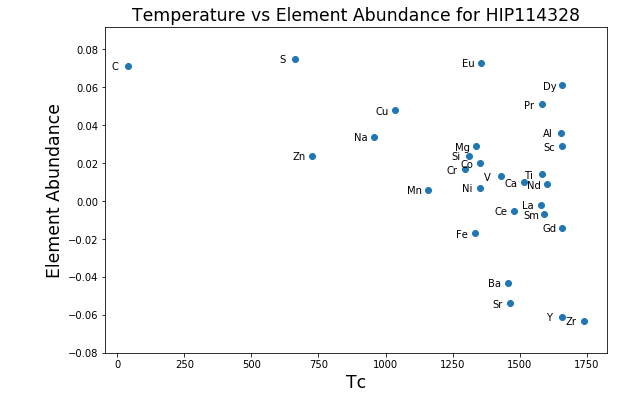

In [379]:
#test for HIP10175, HIP102152
m_b = find_m_b(np.array(xt),np.array(ya),np.array(ze))
print(m_b)
stellar_abundance_plot('HIP114328')